<a href="https://colab.research.google.com/github/camilomarino/DLBioIm/blob/main/Practica_5_Camilo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Práctico 5: Autocodificadores como método de postprocesamiento para mejorar la plausibilidad anatómica.
======

En este práctico implementaremos un autoencoder para mejorar la plausibilidad anatómica de mapas de segmentación irrealistas. Para más información ver la publicación: https://arxiv.org/pdf/2006.13791.pdf


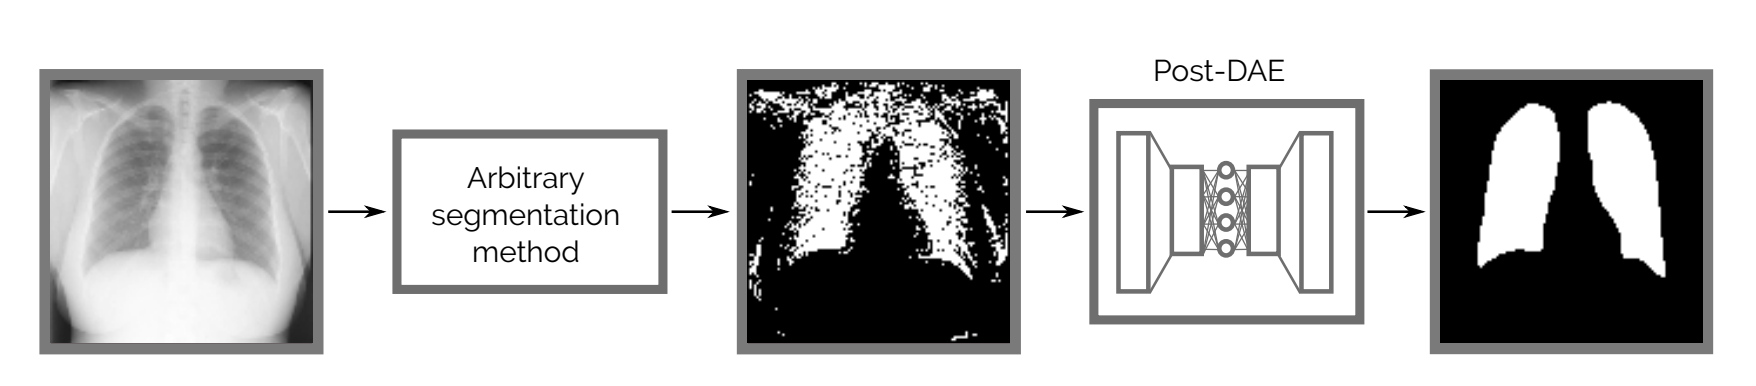

# Cargando imagenes

Descargo las segmentaciones que usaremos desde el repositorio


In [1]:
# ! git clone https://gitlab.com/eferrante/dlmi-udelar.git

Defino la clase Dataset que nos servirá para cargar segmentaciones

In [2]:
import glob
import os
import sys
from random import randint, randrange

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import MNIST

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def erode(img, maxkernelsize=3):
    kernelsize = randrange(2, maxkernelsize + 1)
    kernel = np.ones((kernelsize, kernelsize), np.uint8)
    aux = cv.erode(img, kernel)
    return aux


def dilate(img, maxkernelsize=3):
    kernelsize = randrange(2, maxkernelsize + 1)
    kernel = np.ones((kernelsize, kernelsize), np.uint8)
    aux = cv.dilate(img, kernel)

    return aux


def random_rotate(img, maxangle=5):
    angle = randint(-maxangle, maxangle)

    # grab the dimensions of the image and calculate the center of the image
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our image by 45 degrees around the center of the image
    M = cv.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv.warpAffine(img, M, (w, h), flags=cv.INTER_NEAREST)

    return rotated


def random_rect(img, minsize, maxsize):
    # Set the rectangle size
    h_size = randrange(minsize[0], maxsize[0])
    w_size = randrange(minsize[1], maxsize[1])

    # Filter the area where we can fit a rectangle
    pick_area_h = (h_size // 2 + 1, img.shape[0] - h_size // 2 - 1)
    pick_area_w = (w_size // 2 + 1, img.shape[1] - w_size // 2 - 1)
    pick_area = img[pick_area_h[0] : pick_area_h[1], pick_area_w[0] : pick_area_w[1]]

    # Pick a potential center for the rectangle which contains foreground labels
    potential_centers = np.argwhere(pick_area == 1.0)

    center = potential_centers[randrange(potential_centers.shape[0]), :]

    # Draw a background rectangle in the corresponding center location
    h_1 = center[0]
    h_2 = center[0] + h_size

    w_1 = center[1]
    w_2 = center[1] + w_size

    # print ("Center: {} , {}".format(maxsize[0]//2+1 + center[0], maxsize[1]//2+1 + center[1]))
    aux = cv.rectangle(img.copy(), (w_1, h_1), (w_2, h_2), 0, cv.FILLED)
    # plt.figure()
    # plt.imshow(aux)

    return aux


def random_shape(img, minsize, maxsize, maxshapes):

    trials = randint(1, maxshapes)
    for i in range(trials):
        # Indicates if we are going to corrupt with label 1 or 0
        label_value = randint(0, 1)

        # Indicates the shape of the corruption (0=rectangle, 1=ellipse)
        shape = randint(0, 1)

        # Set the rectangle size
        h_size = randint(minsize[0], maxsize[0])
        w_size = randint(minsize[1], maxsize[1])

        # Filter the area where we can fit a rectangle
        pick_area_h = (h_size // 2 + 1, img.shape[0] - h_size // 2 - 1)
        pick_area_w = (w_size // 2 + 1, img.shape[1] - w_size // 2 - 1)
        pick_area = img[
            pick_area_h[0] : pick_area_h[1], pick_area_w[0] : pick_area_w[1]
        ]

        # Pick a potential center for the rectangle which contains foreground labels
        potential_centers = np.argwhere(pick_area == 1.0 - label_value)

        center = potential_centers[randrange(potential_centers.shape[0]), :]

        if shape == 0:
            # Draw a background rectangle in the corresponding center location
            h_1 = center[0]
            h_2 = center[0] + h_size

            w_1 = center[1]
            w_2 = center[1] + w_size

            # print ("Center: {} , {}".format(maxsize[0]//2+1 + center[0], maxsize[1]//2+1 + center[1]))
            aux = cv.rectangle(
                img.copy(), (w_1, h_1), (w_2, h_2), label_value, cv.FILLED
            )
        else:
            axesLength = (w_size, h_size)

            angle = randrange(0, 360)

            startAngle = 0
            endAngle = 360

            # Blue color in BGR

            # Line thickness of -1 px
            thickness = -1

            # Using cv2.ellipse() method
            # Draw a ellipse with blue line borders of thickness of -1 px
            aux = cv.ellipse(
                img.copy(),
                center,
                axesLength,
                angle,
                startAngle,
                endAngle,
                label_value,
                thickness,
            )

        return aux


class CorruptSegmentationSquare(object):
    """Corrupts a given segmentation to generate a negative sample that can be used when training with discriminative loss.

    Args:
        minsize (tuple): Tuple indicating minimum size in each dimension for the background squares
            that will be removed from the foreground segmentation at random locations.
        maxsize (tuple): Tuple indicating maximum size in each dimension for the background squares
            that will be removed from the foreground segmentation at random locations.

    """

    def __init__(self, minsize, maxsize):
        self.minsize = minsize
        self.maxsize = maxsize

    def __call__(self, sample):
        aux_sample = sample.numpy().squeeze()
        aux_sample = torch.from_numpy(
            np.expand_dims(random_rect(aux_sample, self.minsize, self.maxsize), axis=0)
        )

        return aux_sample


class CorruptSegmentationRandomShapes(object):
    """Corrupts a given segmentation to generate a negative sample that can be used when training with discriminative loss.
       It generates rectangles and ellipses of values foreground and background

    Args:
        minsize (tuple): Tuple indicating minimum size in each dimension corruption shapes
        maxsize (tuple): Tuple indicating maximum size in each dimension corruption shapes
        maxshapes (int): The method will randomly generate between 1 and maxshapes corruptions (with random label values 0 or 1).

    """

    def __init__(self, minsize, maxsize, maxshapes):
        self.minsize = minsize
        self.maxsize = maxsize
        self.maxshapes = maxshapes

    def __call__(self, sample):
        aux_sample = sample.numpy().squeeze()
        aux_sample = torch.from_numpy(
            np.expand_dims(
                random_shape(aux_sample, self.minsize, self.maxsize, self.maxshapes),
                axis=0,
            )
        )

        return aux_sample


class CorruptSegmentationErode(object):
    """Corrupts a given segmentation by eroding it.

    Args:
        maxkernelsize (int): Maximum size of the kernel used to erode
    """

    def __init__(self, maxkernelsize):
        self.maxkernelsize = maxkernelsize

    def __call__(self, sample):
        aux_sample = sample.numpy().squeeze()
        aux_sample = torch.from_numpy(
            np.expand_dims(erode(aux_sample, self.maxkernelsize), axis=0)
        )

        return aux_sample


class CorruptSegmentationDilate(object):
    """Corrupts a given segmentation by dilating it.

    Args:
        maxkernelsize (int): Maximum size of the kernel used to dilate
    """

    def __init__(self, maxkernelsize):
        self.maxkernelsize = maxkernelsize

    def __call__(self, sample):
        aux_sample = sample.numpy().squeeze()
        return torch.from_numpy(
            np.expand_dims(dilate(aux_sample, self.maxkernelsize), axis=0)
        )


class CorruptSegmentationRotate(object):
    """Corrupts a given segmentation by dilating it.

    Args:
        maxkernelsize (int): Maximum size of the kernel used to dilate
    """

    def __init__(self, maxangle=5):
        self.maxangle = maxangle

    def __call__(self, sample):
        aux_sample = sample.numpy().squeeze()

        return torch.from_numpy(
            np.expand_dims(random_rotate(aux_sample, self.maxangle), axis=0)
        )


def toOneHot(im_array):
    """
    Converts numpy array of integers to one hot encoding

    Args:
        im_array: 2D numpy array of integer values, starting from 0.

    Returns:
        A float numpy array of shape (im_array.shape[0], im_array.shape[1], im_array.max() + 1)
        containing the one hot version the original im_array segmentation mask.
    """
    one_hot = np.zeros((im_array.shape[0], im_array.shape[1], im_array.max() + 1))

    layer_idx = np.arange(im_array.shape[0]).reshape(im_array.shape[0], 1)

    component_idx = np.tile(np.arange(im_array.shape[1]), (im_array.shape[0], 1))

    one_hot[layer_idx, component_idx, im_array] = 1

    return one_hot


class DatasetSegmentation(data.Dataset):
    """
    DataLoader for segmentation masks stored in png format
    """

    def __init__(
        self,
        folder_path,
        load_one_hot=True,
        file_extension="*.png",
        replace_labels=None,
        transforms=None,
        batchsize=12,
    ):
        """
        Args:
            load_one_hot: boolean. If True, then a one hot version of the label mask is loaded, else, an integer image is returned
            file_extension: files matching "file_extension" will be loaded
            replace_labels: a list of touples [(label_source1, label_target1), ... (label_sourceN, label_targetN)] indicating that label_sourceN will be replaced by label_targetN after loading.
        """
        super(DatasetSegmentation, self).__init__()
        self.mask_files = glob.glob(os.path.join(folder_path, file_extension))
        self.mask_files.sort()

        self.load_one_hot = load_one_hot
        self.replace_labels = replace_labels
        self.transforms = transforms

    def __getitem__(self, index):
        mask_path = self.mask_files[index]

        im = Image.open(mask_path)

        im_array = np.asarray(im)

        if self.replace_labels is not None:
            for source, target in self.replace_labels:
                # im_array[im_array == source] = target
                im_array = np.where(im_array == source, target, im_array)

        if self.load_one_hot:
            one_hot = toOneHot(im_array)
        else:
            one_hot = im_array.reshape(1, im_array.shape[0], im_array.shape[1])

        one_hot = torch.from_numpy(one_hot).float()

        if self.transforms:
            one_hot = self.transforms(one_hot)

        return one_hot

    def __len__(self):
        return len(self.mask_files)


class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

# Datasets y Dataloaders de imágenes plausibles y no plausibles

Ahora cargaremos imágenes plausibles para entrenar, e imágenes no plausibles para testear.

In [3]:
import importlib

%matplotlib inline
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import MNIST

transforms_jsrt = transforms.Compose(
    [
        transforms.Resize((28, 28), interpolation=Image.NEAREST),
        # transforms.Normalize((0.5,), (0.5,))
    ]
)

# Images path
imgPath = "dlmi-udelar/JSRT/"
test_batch_size = 20

# Defino los datasets
train_dataset = DatasetSegmentation(
    os.path.join(imgPath, "train/"),
    load_one_hot=False,
    replace_labels=[(2, 1), (3, 0)],
    transforms=transforms_jsrt,
)
test_dataset = DatasetSegmentation(
    os.path.join(imgPath, "test_ood/original/"),
    load_one_hot=False,
    replace_labels=[(85, 1), (170, 1), (255, 0)],
    transforms=transforms_jsrt,
)

test_non_plausible_dataset_left_lung = DatasetSegmentation(
    os.path.join(imgPath, "test_ood/nonPlausibleLeftLung/"),
    load_one_hot=False,
    replace_labels=[(85, 1), (170, 1), (255, 0)],
    transforms=transforms_jsrt,
)
test_non_plausible_dataset_right_lung = DatasetSegmentation(
    os.path.join(imgPath, "test_ood/nonPlausibleRightLung/"),
    load_one_hot=False,
    replace_labels=[(85, 1), (170, 1), (255, 0)],
    transforms=transforms_jsrt,
)
test_non_plausible_dataset_hole = DatasetSegmentation(
    os.path.join(imgPath, "test_ood/nonPlausibleHole/"),
    load_one_hot=False,
    replace_labels=[(85, 1), (170, 1), (255, 0)],
    transforms=transforms_jsrt,
)


# Defino los dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

test_non_plausible_left_lung = DataLoader(
    test_non_plausible_dataset_left_lung, batch_size=test_batch_size, shuffle=False
)
test_non_plausible_right_lung = DataLoader(
    test_non_plausible_dataset_right_lung, batch_size=test_batch_size, shuffle=False
)
test_non_plausible_hole = DataLoader(
    test_non_plausible_dataset_hole, batch_size=test_batch_size, shuffle=False
)

/clusteruy/home/cmarino/anaconda3/envs/dlbio/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Visualizamos algunas segmentaciones plausibles de ejemplo

7
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([8, 1, 28, 28])


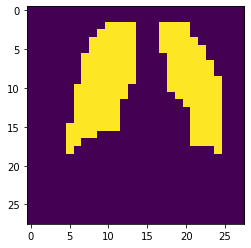

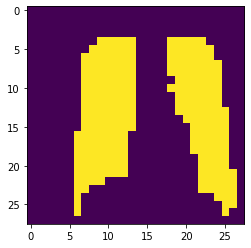

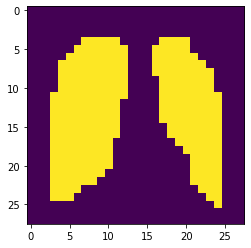

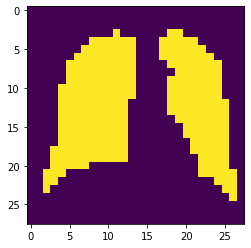

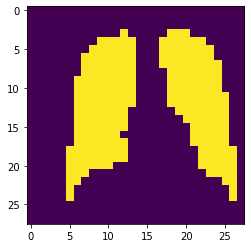

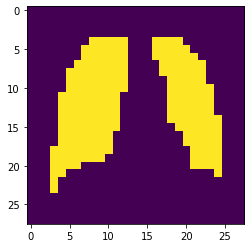

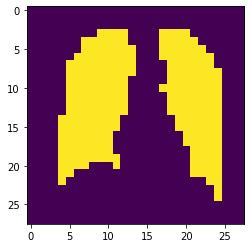

In [4]:
import matplotlib.pyplot as plt

print(len(train_dataloader))
for i, batch in enumerate(train_dataloader):
    print(batch.shape)

    plt.figure()
    plt.imshow(batch[0, :, :].squeeze())

Visualizamos algunas segmentaciones no plausibles de ejemplo. Pueden ver que trabajermos con 3 tipos de no plausibilidad diferente.

1
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])


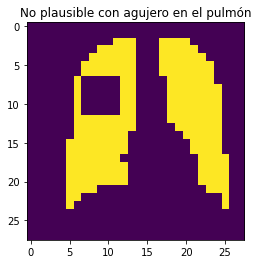

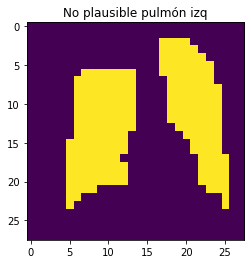

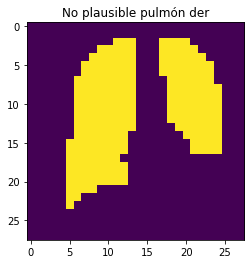

In [5]:
import matplotlib.pyplot as plt

print(len(test_non_plausible_hole))
for i, batch in enumerate(test_non_plausible_hole):
    print(batch.shape)

    plt.figure()
    plt.imshow(batch[0, :, :].squeeze())
    plt.title("No plausible con agujero en el pulmón")

for i, batch in enumerate(test_non_plausible_left_lung):
    print(batch.shape)

    plt.figure()
    plt.imshow(batch[0, :, :].squeeze())
    plt.title("No plausible pulmón izq")

for i, batch in enumerate(test_non_plausible_right_lung):
    print(batch.shape)

    plt.figure()
    plt.imshow(batch[0, :, :].squeeze())
    plt.title("No plausible pulmón der")

In [6]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
%matplotlib inline
import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [7]:
# El parámetro "latent_dims" indicará la dimensionalidad del espacio latente del autocodificador que implementaremos.
latent_dims = 10
num_epochs = 50
batch_size = 32
capacity = 32
learning_rate = 1e-3
use_gpu = True

# Defición del autoencoder

Utilizaremos un autocodificador convolucional con capa totalmente conectada en el cuello de botella, que representará el código latente.

El AE deberá tener dos niveles de pooling antes de llegar a la capa totalmente conectada (cuello de botella). Se recomienda que el primer nivel cuente con 32 feature maps (especificados en el parámetro capacity) y el segundo nivel con 64. La dimensión del espacio latente en una primera instancia deberá ser 2, y luego implementarán otro modelo con dimensión 10 para comparar los resultados. Las capas convolucionales deberán tener función de activación ReLu mientras que la totalmente conectadas no tendrá ninguna.

Para el decoder, pueden utilizar la clase `nn.ConvTranspose2d` que implementa las convoluciones transpuestas, en lugar de usar la estrategia anterior de upsampling + convolution.

La última capa convolucinal deberá generar un solo feature map de salida, y utilizar función de activación sigmoide, para garantizar que el valor de los pixeles se encuentre entre 0 y 1.

In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(1, c, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(c, 64, kernel_size=3, padding=1)
        self.fc = nn.Linear(7 * 7 * 64, latent_dim)
        self.maxpool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # import ipdb; ipdb.set_trace()
        # x: batch_size x 1 x 28 x 28
        x = self.relu(self.conv1(x))  # batch_size x c x 28 x 28
        x = self.maxpool(x)  # batch_size x c x 14 x 14
        x = self.relu(self.conv2(x))  # batch_size x 64 x 14 x 14
        x = self.maxpool(x)  # batch_size x 64 x 7 x 7
        x = x.view((x.size(0), -1))  # batch_size x 3136
        x_latent = self.fc(x)  # batch_size x latent_dim
        return x_latent


class Decoder(nn.Module):
    def __init__(self, latent_dim: int):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(latent_dim, 7 * 7 * 64)
        self.conv2 = nn.ConvTranspose2d(64, c, kernel_size=4, padding=1, stride=2)
        self.conv1 = nn.ConvTranspose2d(c, 1, kernel_size=4, padding=1, stride=2)
        self.relu = nn.ReLU()
        self.sigmoide = nn.Sigmoid()

    def forward(self, x):
        # x: batch_size x latent_dim
        x = self.fc((x))  # batch_size x 3136
        x = x.view((x.size(0), 64, 7, 7))  # batch_size x 64 x 7 x 7
        x = self.relu(self.conv2(x))  # batch_size x c x 14 x 14
        x = self.conv1(x)  # batch_size x 1 x 28 x 28
        x = self.sigmoide(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, latent_dim: int):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon


def ae_loss(recon_x, x):
    # Ya que estamos trabajando con segmentaciones binarias, utilizaremos como error de reconstrucción
    # la entropia cruzada.
    recon_loss = F.binary_cross_entropy(
        recon_x.view(-1, 784), x.view(-1, 784), reduction="sum"
    )

    return recon_loss

Train VAE
--------

In [10]:
def trainer_ae(ae: nn.Module):
    optimizer = torch.optim.Adam(
        params=ae.parameters(), lr=learning_rate, weight_decay=1e-5
    )
    num_params = sum(p.numel() for p in ae.parameters() if p.requires_grad)
    print("Number of parameters: %d" % num_params)
    # set to training mode
    ae.train()

    train_loss_avg = []

    print("Training ...")
    for epoch in range(num_epochs):
        train_loss_avg.append(0)
        num_batches = 0

        for image_batch in train_dataloader:

            image_batch = image_batch.to(device)

            # ae reconstruction
            image_batch_recon = ae(image_batch)

            # reconstruction error
            loss = ae_loss(image_batch_recon, image_batch)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()

            train_loss_avg[-1] += loss.item()
            num_batches += 1

        train_loss_avg[-1] /= num_batches
        print(
            "Epoch [%d / %d] average reconstruction error: %f"
            % (epoch + 1, num_epochs, train_loss_avg[-1])
        )
    return train_loss_avg


ae_2 = Autoencoder(2).to(device)
ae_10 = Autoencoder(10).to(device)
train_loss_avg_2 = trainer_ae(ae_2)
train_loss_avg_10 = trainer_ae(ae_10)

Number of parameters: 67811
Training ...
Epoch [1 / 50] average reconstruction error: 16475.621582
Epoch [2 / 50] average reconstruction error: 14684.797154
Epoch [3 / 50] average reconstruction error: 11515.587960
Epoch [4 / 50] average reconstruction error: 6600.289150
Epoch [5 / 50] average reconstruction error: 5532.710589
Epoch [6 / 50] average reconstruction error: 5237.580880
Epoch [7 / 50] average reconstruction error: 5089.172956
Epoch [8 / 50] average reconstruction error: 5038.296596
Epoch [9 / 50] average reconstruction error: 4944.944929
Epoch [10 / 50] average reconstruction error: 4870.978620
Epoch [11 / 50] average reconstruction error: 4770.478237
Epoch [12 / 50] average reconstruction error: 4593.830723
Epoch [13 / 50] average reconstruction error: 4396.848110
Epoch [14 / 50] average reconstruction error: 4247.007533
Epoch [15 / 50] average reconstruction error: 4179.856498
Epoch [16 / 50] average reconstruction error: 4128.708670
Epoch [17 / 50] average reconstructio

Plot Training Curve
--------------------

Text(0.5, 0.98, 'Funciones de loss en train')

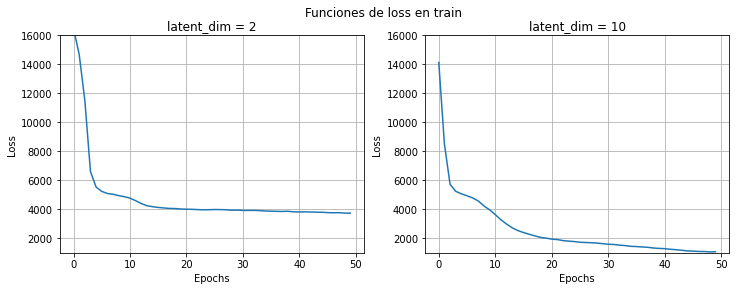

In [11]:
import matplotlib.pyplot as plt


def plot_loss(train_loss_avg, ax, title: str = None):
    ax.plot(train_loss_avg)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.grid(True)
    ax.set_ylim((1_000, 16_000))
    if title is not None:
        ax.set_title(title)


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_loss(train_loss_avg_2, ax[0], title="latent_dim = 2")
plot_loss(train_loss_avg_10, ax[1], title="latent_dim = 10")
fig.suptitle("Funciones de loss en train")

Evaluate on the Test Set
-------------------------

In [12]:
def evaluate_ae(ae):
    # set to evaluation mode
    ae.eval()

    test_loss_avg, num_batches = 0, 0
    for image_batch in test_dataloader:

        with torch.no_grad():

            image_batch = image_batch.to(device)

            # vae reconstruction
            image_batch_recon = ae(image_batch)

            # reconstruction error
            loss = ae_loss(image_batch_recon, image_batch)

            test_loss_avg += loss.item()
            num_batches += 1

    test_loss_avg /= num_batches
    return test_loss_avg


print(f"Average reconstruction error with latent_dim = 2  : {evaluate_ae(ae_2):.2f}")
print()
print(f"Average reconstruction error with latent_dim = 10 : {evaluate_ae(ae_10):.2f}")

Average reconstruction error with latent_dim = 2  : 2530.11

Average reconstruction error with latent_dim = 10 : 1346.34


Visualize Reconstructions
--------------------------

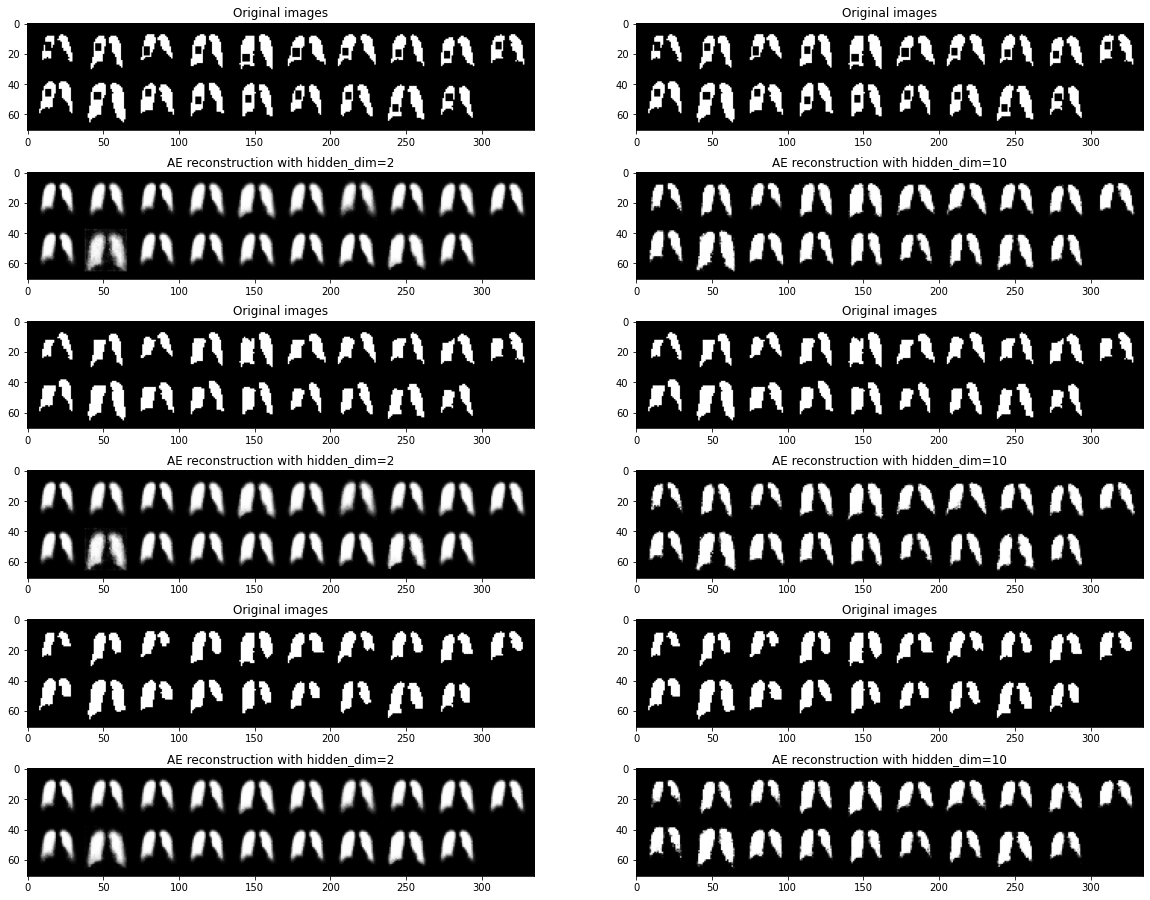

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils


def visualize_recontructions(ae, ax, hidden_dim):
    ae.eval()

    # This function takes as an input the images to reconstruct
    # and the name of the model with which the reconstructions
    # are performed
    def to_img(x):
        x = x.clamp(0, 1)
        return x

    def show_image(img, ax):
        img = to_img(img)
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title("Original images")

    def visualise_output(images, model, ax):

        with torch.no_grad():

            images = images.to(device)
            images = model(images)
            images = images.cpu()
            images = to_img(images)
            np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
            ax.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
            ax.set_title(f"AE reconstruction with hidden_dim={hidden_dim}")

    images = iter(test_non_plausible_hole).next()

    show_image(torchvision.utils.make_grid(images[1:50], 10, 5), ax[0])

    visualise_output(images, ae, ax[1])

    images = iter(test_non_plausible_left_lung).next()

    show_image(torchvision.utils.make_grid(images[1:50], 10, 5), ax[2])

    visualise_output(images, ae, ax[3])

    images = iter(test_non_plausible_right_lung).next()

    show_image(torchvision.utils.make_grid(images[1:50], 10, 5), ax[4])

    visualise_output(images, ae, ax[5])


fig, ax = plt.subplots(6, 2, figsize=(20, 16))
visualize_recontructions(ae_2, ax[:, 0], hidden_dim=2)
visualize_recontructions(ae_10, ax[:, 1], hidden_dim=10)

# Opcional: Dice y Hausdorff

In [15]:
test_non_plausible_hole

In [38]:
import medpy.metric.binary as metrics
# ESTA FUNCION A CONTINUACION ES INCORRECTA
def eval_loader(model, test_dataloader, test_non_plausible):
    loader_dice = []
    loader_haussdorf = []

    model.eval()
    with torch.no_grad():
        for sample_batched in zip(test_dataloader, test_non_plausible):
            images, labels = sample_batched[0].to(device), sample_batched[1].to(device)
            # Modelo de 1 sola clase de salida
            # Tomo la primer imagen del batch, y el único canal ya que tiene solo una clase como salida
            segs = model(images)

            for seg, label in zip(segs, labels):
                seg = seg[0]  # me quedo con el unico canal

                # Binarizo la segmentacion (que se encuentra en el rango 0-1 por la sigmoidea)
                binary = seg > 0.5
                try:
                    dice = metrics.dc(binary.cpu().numpy(), label.cpu().numpy())
                    loader_dice.append(dice)
                    haussdorf = metrics.hd(binary.cpu().numpy(), label.cpu().numpy())
                    loader_haussdorf.append(haussdorf)
                except RuntimeError:
                    pass

    return np.array(loader_dice).mean(), np.array(loader_haussdorf).mean()


print(eval_loader(ae_2, test_dataloader, test_non_plausible_hole))
print(eval_loader(ae_2, test_dataloader, test_non_plausible_hole))

/tmp/ipykernel_7552/2149902513.py:28: RuntimeWarning: Mean of empty slice.
  return np.array(loader_dice).mean(), np.array(loader_haussdorf).mean()
/clusteruy/home/cmarino/anaconda3/envs/dlbio/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.8210947608690609, nan)

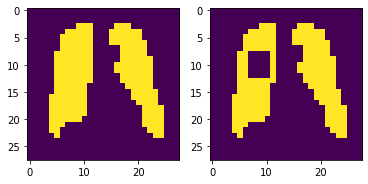

In [34]:
idx = 17
x, y = next(iter(zip(test_dataloader, test_non_plausible_hole)))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x.numpy()[idx, 0])
ax[1].imshow(y.numpy()[idx, 0])

In [28]:
y.numpy().shape

(1, 28, 28)

# Entregable

Deberán implementar el autocodificador convolucional, y entrenarlo usando el dataloader de imágenes plausibles.

Luego, utilizando los dataloaders. de test de imágenes no plausibles, deberán reconstruirlas. Deberán entrenar un AE con dimensión de espacio latente `latent_dim=2` y otro con dimensión `latent_dim=10`, comparar la calidad de las reconstrucciones obtenidas y comentar al respecto.

**Opcional:** Para evaluar si el método efectivamente mejora la calidad de las segmentaciones, deberán computar el coeficiente Dice y la distancia de Hausdorff entre las segmentaciones ground truth (que se encuentran en el dataloader `test_dataloader`) y las versiones no plausibles, antes y después de haberlas reconstruido. Mostrar estos resultados en un boxplot y analizarlos.